In [1]:
import numpy as np
import pandas as pd
from pandas_datareader import data as pdr
import matplotlib.pyplot as plt
from scipy.stats import norm, gmean, cauchy
import seaborn as sns
from datetime import datetime, timedelta
import yfinance as yfin

yfin.pdr_override()
%matplotlib inline

In [2]:
def import_stock_data(tickers, start = '2010-1-1'):
    data = pd.DataFrame()
    if len(tickers) == 1:
        data[tickers[0]] = pdr.get_data_yahoo(tickers[0], start = start)['Adj Close']
        data = pd.DataFrame(data)
    else:
        for t in tickers:
            data[t] = pdr.get_data_yahoo(t, start = start)['Adj Close']
    return(data)

In [3]:
import_stock_data(['AAPL','GOOG'])

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,AAPL,GOOG
Date,,
2010-01-04,6.496295,15.610239
2010-01-05,6.507526,15.541497
2010-01-06,6.404016,15.149715
2010-01-07,6.392177,14.797037
2010-01-08,6.434673,14.994298
...,...,...
2023-05-26,175.429993,125.430000
2023-05-30,177.300003,124.639999
2023-05-31,177.250000,123.370003


In [4]:
def log_returns(data):
    return (np.log(1+data.pct_change()))
def simple_returns(data):
    return ((data/data.shift(1))-1)

In [5]:
def market_data_combination(data, mark_ticker = "^GSPC", start='2010-1-1'):
    market_data = import_stock_data([mark_ticker], start)
    market_rets = log_returns(market_data).dropna()
    ann_return = np.exp(market_rets.mean()*252).values-1
    data = data.merge(market_data, left_index=True, right_index=True)
    return data, ann_return

In [6]:
def beta_sharpe(data, mark_ticker = "^GSPC", start='2010-1-1', riskfree = 0.025):
    
    """
    Input: 
    1. data: dataframe of stock price data
    2. mark_ticker: ticker of the market data you want to compute CAPM metrics with (default is ^GSPC)
    3. start: data from which to download data (default Jan 1st 2010)
    4. riskfree: the assumed risk free yield (US 10 Year Bond is assumed: 2.5%)
    
    Output:
    1. Dataframe with CAPM metrics computed against specified market procy
    """
    # Beta
    dd, mark_ret = market_data_combination(data, mark_ticker, start)
    log_ret = log_returns(dd)
    covar = log_ret.cov()*252
    covar = pd.DataFrame(covar.iloc[:-1,-1])
    mrk_var = log_ret.iloc[:,-1].var()*252
    beta = covar/mrk_var
    
    stdev_ret = pd.DataFrame(((log_ret.std()*250**0.5)[:-1]), columns=['STD'])
    beta = beta.merge(stdev_ret, left_index=True, right_index=True)
    
    # CAPM
    for i, row in beta.iterrows():
        beta.at[i,'CAPM'] = riskfree + (row[mark_ticker] * (mark_ret-riskfree))
    # Sharpe
    for i, row in beta.iterrows():
        beta.at[i,'Sharpe'] = ((row['CAPM']-riskfree)/(row['STD']))
    beta.rename(columns={"^GSPC":"Beta"}, inplace=True)
    
    return beta

In [7]:
def montecarlo_sharpe_optimal_portfolio(tickers, trials, riskfree=0.025, plot_eff = True, start_date = '2010-1-1', end_date=None):
    if end_date == None:
        end_date = datetime.today().strftime('%Y-%m-%d')
    
    data = import_stock_data(tickers)
    data, mark_ret = market_data_combination(data)
    allWeights = np.zeros((trials, len(data.columns)))
    allReturns = np.zeros(trials)
    allVolatility = np.zeros(trials)
    allSharpeValues = np.zeros(trials)
    
    log_return = log_returns(data)
    
    for t in range(trials):
        weights = np.random.rand(len(data.columns))
        weights = weights/np.sum(weights) 
        allWeights[t,:]=weights
        
        allReturns[t] = np.sum((log_return.mean()*weights)*252)
        
        allVolatility[t] = np.sqrt(np.dot(weights.T, np.dot(log_return.cov()*252, weights)))
        
        allSharpeValues[t] = (allReturns[t]-riskfree)/allVolatility[t]
    
    maxsharpe = allSharpeValues.max()
    pointsharpe = allSharpeValues.argmax()
    weightSharpe = allWeights[pointsharpe]
    x_sharpe = allVolatility[pointsharpe]
    y_sharpe = allReturns[pointsharpe]
    
    maxret = allReturns.max()
    pointret = allReturns.argmax()
    weightRet = allWeights[pointret]
    x_ret = allVolatility[pointret]
    y_ret = allReturns[pointret]
    
 
    if plot_eff == True:
        plt.figure(figsize=(14,9))
        plt.scatter(allVolatility, allReturns, c=allSharpeValues, cmap='plasma')
        plt.colorbar(label='Sharpe Ratio')
        plt.xlabel('Volatility')
        plt.ylabel('Expected Return')
        
        plt.scatter(x_sharpe,y_sharpe,c='black')
        plt.scatter(x_ret, y_ret, c='black')
       
    optim_dic = []
    for i in range(len(tickers)):
        optim_dic.append({'ticker':tickers[i],'Weight':weightSharpe[i]})
    print(pd.DataFrame(optim_dic))

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
  ticker    Weight
0   MSFT  0.696529
1   AMZN  0.295921
2   AMZN  0.007550


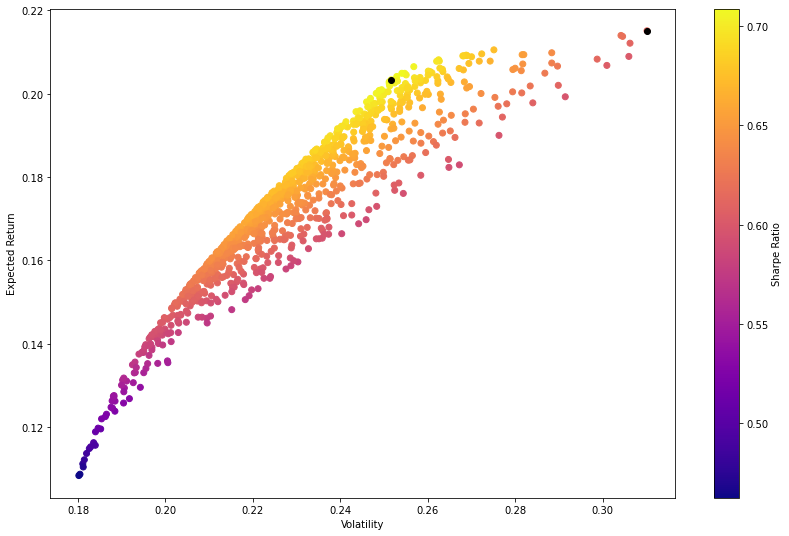

In [8]:
montecarlo_sharpe_optimal_portfolio(['MSFT','AMZN','AMZN'],1000)